In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [54]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [72]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [54]:
data_classification.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,credit_history_years,loan_status
0,744.0,126.0,0.0917,50000.0,4.66,140.27,622.0,0.768,710.0,7700.0,5913.0,76.8,64898.0,11,0
1,739.0,151.0,0.1249,60000.0,16.14,568.64,800.0,0.865,685.0,27700.0,23949.0,87.1,1831.0,12,0
2,614.0,292.0,0.0819,75000.0,24.67,244.41,350.0,0.858,680.0,20300.0,17425.0,96.3,19333.0,24,0
3,604.0,206.0,0.2449,67500.0,15.81,492.45,301.0,0.396,675.0,53300.0,21088.0,39.4,6661.0,17,1
4,654.0,424.0,0.1199,70000.0,23.70,332.10,770.0,0.847,660.0,22725.0,19249.0,94.9,25393.0,36,0


In [55]:
"""data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)"""

data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

In [56]:
train_classification = pd.concat([X_train, y_train], axis=1)

data_x = train_classification.drop(columns = 'loan_status')
data_y = train_classification[['loan_status']]

In [57]:
from imblearn.over_sampling import SMOTE

class_counts = train_classification[['loan_status']].value_counts()

n_majority = class_counts[0]
n_target_minority = n_majority // 2

smote = SMOTE(sampling_strategy={1: n_target_minority}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(data_x, data_y)

resample_data = pd.concat([X_resampled, y_resampled], axis = 1)

resample_data['loan_status'].value_counts()

loan_status
0    718935
1    359467
Name: count, dtype: int64

## CTGAN 적용

In [3]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Real_Datasets/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

In [4]:
len(label1_data)

217789

In [5]:
label1_data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

def drift_slope(y: np.ndarray) -> float:
    X = np.arange(len(y)).reshape(-1, 1)
    coef = LinearRegression().fit(X, y).coef_[0]
    return float(abs(coef))

def epoch_tail(df_epoch: pd.DataFrame, frac: float = 0.2):
    """epoch 기준 마지막 frac만 슬라이스"""
    max_ep = float(df_epoch["epoch"].max())
    start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= start].copy()
    return tail, start, max_ep

def stability_metrics_from_lossdf(loss_df: pd.DataFrame, tail_frac=0.2):
    """
    loss_df: columns must include ['epoch','g_loss','d_loss'] (get_loss_values() 반환 포맷)
    """
    # epoch별 평균으로 정리 (step 로그가 섞여있을 가능성 대비)
    df_epoch = (loss_df[["epoch","g_loss","d_loss"]]
                .dropna()
                .groupby("epoch", as_index=False)
                .mean()
                .sort_values("epoch"))

    tail, start, max_ep = epoch_tail(df_epoch, tail_frac)
    yg, yd = tail["g_loss"].to_numpy(), tail["d_loss"].to_numpy()

    metrics = {
        "TailStartEpoch": float(start),
        "MaxEpoch": float(max_ep),
        "n_tail_epochs": int(len(tail)),
        "Var_G": float(np.var(yg)),
        "Var_D": float(np.var(yd)),
        "Drift_G": drift_slope(yg),
        "Drift_D": drift_slope(yd),
    }
    return metrics, df_epoch, tail

# ======================
# 2) CTGAN 학습 + 손실 추출
# ======================
# (예시) 라벨 1 데이터프레임: label1_data
# 범주형 지정
discrete_columns = ['debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose','grade',]

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=label1_data)
for col in discrete_columns:
    metadata.update_column(column_name=col, sdtype='categorical')

synthesizer = CTGANSynthesizer(
    metadata,
    epochs=300,
    batch_size=128,
    cuda=torch.cuda.is_available(),
    verbose=True
)

print("🧪 Start training CTGAN on class 1 data...")
synthesizer.fit(label1_data)
print("✅ Training completed.")

# SDV >= 특정 버전에서 제공: epoch, g_loss, d_loss 포함 DF 반환
loss_df = synthesizer.get_loss_values()   # <-- 네가 말한 API 사용
# 확인 및 저장(옵션)
print(loss_df.head())
loss_df.to_csv("ctgan_loss_values.csv", index=False)

# ======================
# 3) 안정성 지표 계산
# ======================
metrics, df_epoch, tail = stability_metrics_from_lossdf(loss_df, tail_frac=0.2)
print(metrics)

# ======================
# 4) (옵션) 플롯
# ======================
plt.figure(figsize=(9,5))
plt.plot(df_epoch["epoch"], df_epoch["g_loss"], label="G Loss", linewidth=1)
plt.plot(df_epoch["epoch"], df_epoch["d_loss"], label="D Loss", linewidth=1)
plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CTGAN G/D Loss (epoch-mean)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6); plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["g_loss"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["d_loss"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6); plt.tight_layout()
plt.show()

🧪 Start training CTGAN on class 1 data...


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
import pandas as pd
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import torch
import os


N_CLS_PER_GEN = 540_000
OUTPUT_PATH = 'CTGAN_loss.csv'


#discrete_columns = ['zip_code', 'grade', 'term_months', 'loan_status']
# zip_code one-hot-encoded : 185259
discrete_columns = ['zip_code', 'grade', 'term_months', 'loan_status']

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=label1_data)

for column in discrete_columns:
    metadata.update_column(column_name=column, sdtype='categorical')

synthesizer = CTGANSynthesizer(
    metadata,
    epochs=300,
    cuda=torch.cuda.is_available(),  # CUDA 사용 여부
    verbose=False
)

print("🧪 Start training CTGAN on class 1 data...")
synthesizer.fit(label1_data)
print("✅ Training completed.")

🧪 Start training CTGAN on class 1 data...
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name       Est # of Columns (CTGAN)
last_fico_range_high       11
mo_sin_old_rev_tl_op       11
int_rate                   11
annual_inc                 11
dti                        11
installment                11
zip_code                   185294
revol_util                 11
fico_range_low             11
total_rev_hi_lim           11
revol_bal                  11
bc_util                    11
avg_cur_bal                11
total_il_high_credit_limit 11
grade                      7
total_pymnt                11
total_pymnt_inv            11
loan_amnt                  11
credit_history_years       11
term_months                25
loan_status                1

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns tha

MemoryError: Unable to allocate 62.0 GiB for an array with shape (359467, 185294) and data type bool

In [82]:
print(f"🔄 Sampling {N_CLS_PER_GEN} synthetic samples...")
synthetic_data = synthesizer.sample(num_rows=N_CLS_PER_GEN)

os.makedirs("ctgan_output", exist_ok=True)
output_file = os.path.join("ctgan_output", OUTPUT_PATH)
synthetic_data.to_csv(output_file, index=False)
print(f"✅ Synthetic data saved to: {output_file}")

🔄 Sampling 500000 synthetic samples...
✅ Synthetic data saved to: ctgan_output\synthetic_smotified_ctgan_data_class1.csv


## CTGAN 학습

In [33]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/ctgan_output/synthetic_smotified_ctgan_data_class1.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [4]:
fake.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [34]:
fake['zip_code'] = fake['zip_code'].astype(str).str[:3].astype(float)

In [35]:
fake['zip_code'].value_counts()

zip_code
245.0    634
429.0    623
707.0    618
984.0    618
586.0    617
        ... 
211.0    502
857.0    490
368.0    488
328.0    482
999.0    320
Name: count, Length: 900, dtype: int64

In [36]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [37]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [38]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [39]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    674231
Name: count, dtype: int64

In [40]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68575	validation_1-logloss:0.66773
[1]	validation_0-logloss:0.67900	validation_1-logloss:0.66149
[2]	validation_0-logloss:0.67239	validation_1-logloss:0.65538
[3]	validation_0-logloss:0.66590	validation_1-logloss:0.64939
[4]	validation_0-logloss:0.65954	validation_1-logloss:0.64351
[5]	validation_0-logloss:0.65329	validation_1-logloss:0.63776
[6]	validation_0-logloss:0.64717	validation_1-logloss:0.63211
[7]	validation_0-logloss:0.64115	validation_1-logloss:0.62657
[8]	validation_0-logloss:0.63525	validation_1-logloss:0.62113
[9]	validation_0-logloss:0.62945	validation_1-logloss:0.61580
[10]	validation_0-logloss:0.62378	validation_1-logloss:0.61058
[11]	validation_0-logloss:0.61818	validation_1-logloss:0.60543
[12]	validation_0-logloss:0.61267	validation_1-logloss:0.60039
[13]	validation_0-logloss:0.60729	validation_1-logloss:0.59543
[14]	validation_0-logloss:0.60198	validation_1-logloss:0.59057
[15]	validation_0-logloss:0.59677	validation_1-logloss:0.58579
[1

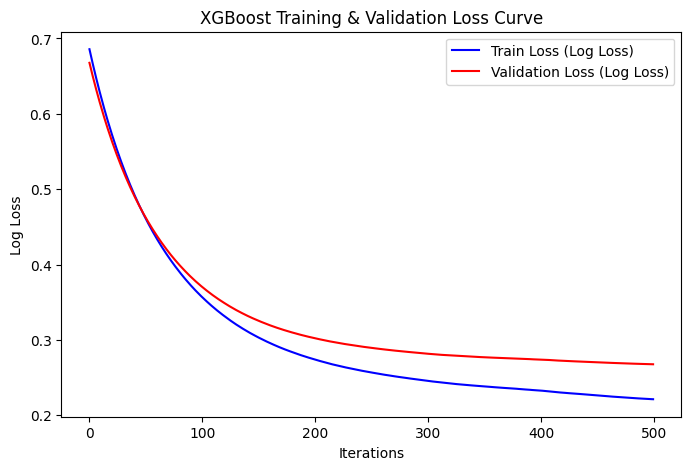

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93    599114
           1       0.66      0.85      0.74    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.87      0.84    744306
weighted avg       0.90      0.89      0.89    744306



In [42]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [43]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[536026  63088]
 [ 21907 123285]]

True Positives (TP): 123285
False Positives (FP): 63088
True Negatives (TN): 536026
False Negatives (FN): 21907


In [47]:
y_pred = y_pred.ravel()
y_test = y_test.values.ravel()  # 또는 y_test.to_numpy().ravel()

FP_idx = np.where((y_pred == 1) & (y_test == 0))[0]
FN_idx = np.where((y_pred == 0) & (y_test == 1))[0]

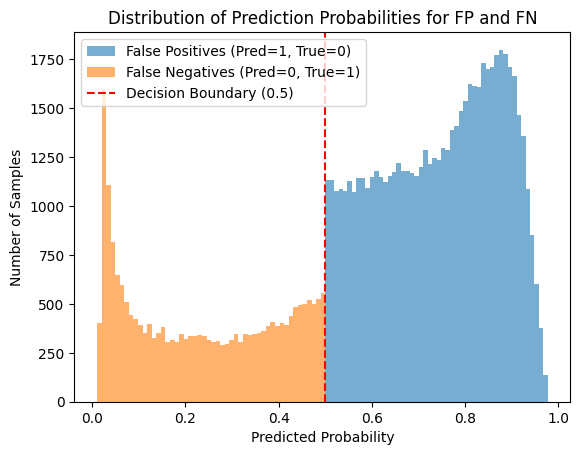

In [48]:
import matplotlib.pyplot as plt

FP_probs = y_prob[FP_idx]
FN_probs = y_prob[FN_idx]

plt.hist(FP_probs, bins=50, alpha=0.6, label='False Positives (Pred=1, True=0)')
plt.hist(FN_probs, bins=50, alpha=0.6, label='False Negatives (Pred=0, True=1)')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Samples')
plt.legend()
plt.title('Distribution of Prediction Probabilities for FP and FN')
plt.show()


In [49]:
# 경계에 가까운 FP/FN 추출
FP_borderline_idx = FP_idx[(FP_probs > 0.4) & (FP_probs < 0.6)]
FN_borderline_idx = FN_idx[(FN_probs > 0.4) & (FN_probs < 0.6)]

# 해당 샘플 출력
FP_borderline_samples = X_test.iloc[FP_borderline_idx]
FN_borderline_samples = X_test.iloc[FN_borderline_idx]

print(f"FP (0.4<x<0.6) length : {len(FP_borderline_samples)}\nFN (0.4<x<0.6)length : {len(FN_borderline_samples)}")


FP (0.4<x<0.6) length : 11605
FN (0.4<x<0.6)length : 4891


## CTGAN portfolio

In [25]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [26]:
drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['loan_amnt'])/test_regression['loan_amnt']

train_regression = data.copy()

train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()

fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['loan_amnt'])/fake_regression['loan_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total = pd.concat([train_regression, fake_regression])

data_x = train_total.drop(columns='return')
data_y = train_total[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_scaled = scaler.fit_transform(data_x)

X_train = data_x_scaled
y_train = data_y

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train, y_train)

#print(reg.coef_)
y_pred = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
print("R²:", r2_score(test_y, y_pred))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.2032763508245865
R²: -0.4484116881579365


In [27]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

,Average Return,Std Dev,Sharpe Ratio
0,13.221608,0.090576,1.459723


## Fake and original df 분석

In [19]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train_label_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

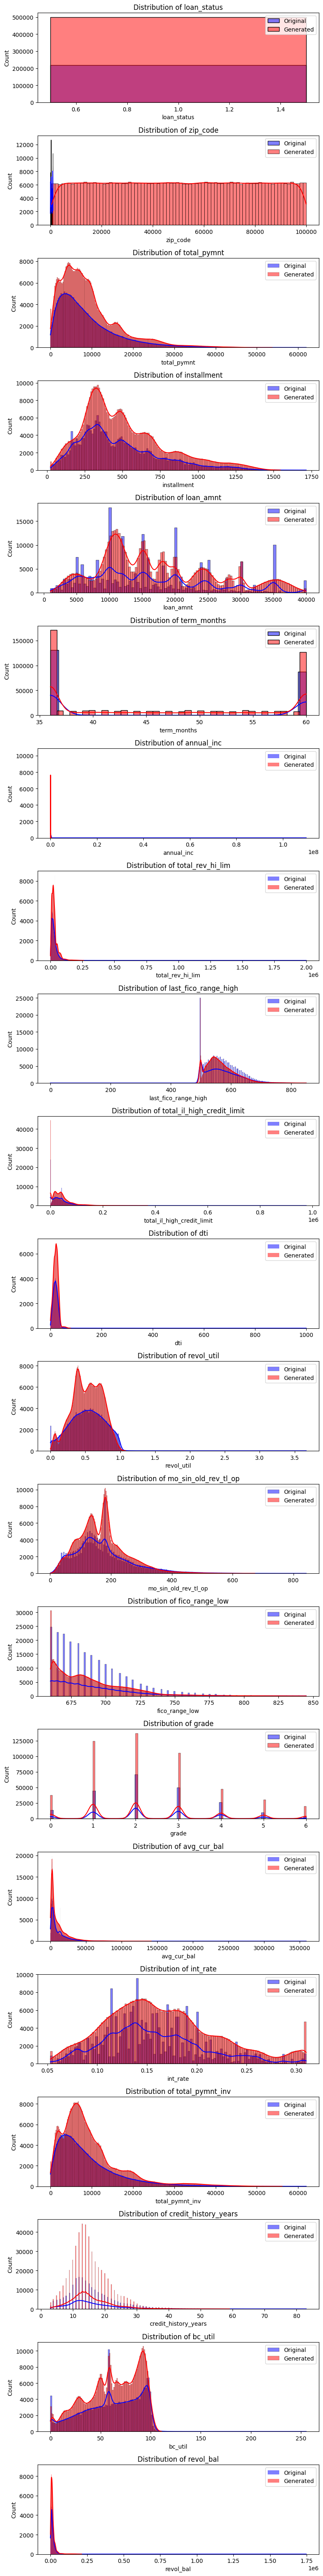

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()